# GO, Parse & Export

In [1]:
import pandas as pd
import json
%run settings/db_connect.ipynb

In [2]:
# treba mi parser jer sadrzi Term definiciju
%run parsers/obo_parser.py 

In [3]:
with open("data/IN/go.json", "r") as obo_file:
    term_list = [Term(t['id'], t) for t in json.load(obo_file)]

In [4]:
goterms_df = []
go_relations_df = []

existing_go_set = set(t.id for t in term_list)

for t in term_list:
    # Mogu da koristim dict umesto tuple ali izgubicu redosled a OrderDict je ruznije praviti od dict objekta za ovaj slucaj
    term_entry = {"id": t.id, 
                  "is_obsolete": t.is_obsolete, 
                  "name": t.name,
                  "namespace":  t.namespace_short(),
                  "def": t.definition[0],
                  "comment":  t.comment,
                  "xrefs": t.xref,
                 }
    goterms_df.append(term_entry)
    
    if t.replaced_by:
        go_relations_df.append( (t.id, t.replaced_by, 'replaced_by') )
    go_relations_df.extend( (t.id, go, rel_type) for rel_type in ['is_a', 'consider'] for go in t.__dict__.get(rel_type) or [])
    go_relations_df.extend( (t.id, go, rel_type) for rel_type, go in t.relationship if go in existing_go_set)

    
goterms_df = pd.DataFrame(goterms_df).set_index('id') \
    [['is_obsolete', 'name', 'namespace', 'def', 'comment', 'xrefs']]
    
go_relations_df = pd.DataFrame(go_relations_df, columns=['start_id', 'end_id', 'type'])
non_existing_terms = go_relations_df[ ~ go_relations_df.end_id.isin(existing_go_set)]
go_relations_df = go_relations_df[go_relations_df.end_id.isin(existing_go_set)]

In [5]:
print('non existing relacije pokazuju na:', set(x[:2] for x in non_existing_terms.end_id))
non_existing_terms

non existing relacije pokazuju na: {'GO'}


,start_id,end_id,type
18404,GO:0015223,GO:0051183,consider
18611,GO:0015339,GO:0015563,consider
18614,GO:0015340,GO:0015563,consider
18619,GO:0015342,GO:0015563,consider
18649,GO:0015356,GO:0015563,consider
18782,GO:0015429,GO:0015246,consider
20663,GO:0016563,GO:0001071,consider
20666,GO:0016564,GO:0001071,consider
21122,GO:0016986,GO:0001071,consider
25865,GO:0022815,GO:0022891,replaced_by


In [11]:
goterms_df.to_sql('goterms', db_engine, if_exists='append')
go_relations_df.to_sql('go_relations', db_engine, if_exists='append', index=None)

Export for Neo4j

In [205]:
sql(""" select id ":ID", 'GOTerm' ":LABEL", namespace ":LABEL", *  from goterms""").to_csv('db/neo4j/goterms.csv')
sql(""" select start_id ":START_ID", end_id ":END_ID", type ":TYPE"  from go_relations""").to_csv('db/neo4j/go_relations.csv')

# Keywords, Parse & Export

In [6]:
%run parsers/keywords_parser.ipynb
kw_list = parse_keywlist('data/IN/keywlist.txt')
kw_name_dict = {rec.get_name(): rec for rec in kw_list}

In [7]:
keywords_df = []
kw_parent_df = []
kw2go = []

for kw in kw_list:
    # Mogu da koristim dict umesto tuple ali izgubicu redosled a ovde je OrderDict ruznije praviti od dict
    kw_entry = (kw.AC, kw.get_name(), kw.get_category(), kw.get_category_name(), kw.DE, kw.SY, kw.WW)
    keywords_df.append(kw_entry)

    kw_parent_df.extend( (kw.AC, p) for p in kw.HI)
    kw2go.extend( (kw.AC, go) for go in kw.GO)

    
keywords_df = pd.DataFrame(keywords_df, columns=['ac', 'name', 'category', 'category_name', 'def', 'synonyms', 'ww']).set_index('ac')
kw_parent_df = pd.DataFrame(kw_parent_df, columns=['kw', 'parent'])
kw2go = pd.DataFrame(kw2go, columns=['kw', 'go'])


In [8]:
kw2go[ ~ kw2go['go'].isin(existing_go_set)] # nema nepostojecih veza

,kw,go


In [15]:
keywords_df.to_sql("keywords", db_engine, if_exists='append')
kw_parent_df.to_sql("kw_parent", db_engine, if_exists='append', index=False)
kw2go.to_sql("kw2go", db_engine, if_exists='append', index=False)

Export for Neo4j

In [212]:
sql(""" select ac ":ID", 'Keyword' ":LABEL", *  from keywords""").to_csv('db/neo4j/keywords.csv')

sql(""" 
select kw ":START_ID", parent ":END_ID", 'parent' ":TYPE"  from kw_parent
union
select kw ":START_ID", go ":END_ID", 'map_to' ":TYPE"  from kw2go
""").to_csv('db/neo4j/kw_relations.csv')

# Proteins Export

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

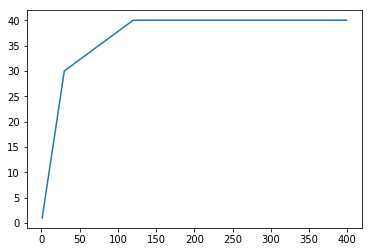

In [99]:
def is_disorderd_40(raw, regions):
    return any(l >=40 for _,_,l in regions)

def linear_limit(l): # preslikava region izmedju 30-80 
    if l > 120:  return 40
    if l <  30:  return l
    
    return  (l-30)/(120-30)*10 + 30

def is_disorderd_40_smart(raw, regions):
    return any(l >=linear_limit(len(raw)) for _,_,l in regions)

xs = np.arange(1, 400)
plt.plot(xs, [linear_limit(x) for x in xs])

In [55]:
import pickle
with open('data/predictions/vsl2b_valid.pickle', 'rb') as f:
    vsl2b_valid = pickle.load(f)
with open('data/predictions/vsl2b_random.pickle', 'rb') as fr:
    vsl2b_random = pickle.load(fr)
with open('data/predictions/vsl2b_uniform.pickle', 'rb') as fu:
    vsl2b_uniform = pickle.load(fu)

### OVO MORA BITI POPRAVLJENO !!!


In [100]:
valid_proteins_df = pd.DataFrame( [(ac, len(raw)) for (ac,raw,_) in vsl2b_valid], columns=['ac', 'len'] ).set_index('ac')


-------------------------

In [101]:
valid_proteins_df['dis40'] = [is_disorderd_40(raw, regions) for _,raw,regions in vsl2b_valid]
valid_proteins_df['dis40_random'] = [is_disorderd_40(raw, regions) for _,raw,regions in vsl2b_random]
valid_proteins_df['dis40_uniform'] = [is_disorderd_40(raw, regions) for _,raw,regions in vsl2b_uniform]
valid_proteins_df['dis_smart'] = [is_disorderd_40_smart(raw, regions) for _,raw,regions in vsl2b_valid]
valid_proteins_df['dis_smart_random'] = [is_disorderd_40_smart(raw, regions) for _,raw,regions in vsl2b_random]

valid_proteins_df.head()

,len,dis40,dis40_random,dis40_uniform,dis_smart,dis_smart_random
ac,,,,,,
A0A060X6Z0,489,True,True,False,True,True
A0A068FIK2,1033,True,True,False,True,True
A0A075F932,421,True,False,False,True,False
A0A078CGE6,1299,True,True,False,True,True
A0A086F3E3,192,False,True,False,False,True


### Save to valid_proteins

In [57]:
valid_proteins_df.to_sql("valid_proteins", db_engine, if_exists='append')

InternalError: (psycopg2.InternalError) cannot drop table valid_proteins because other objects depend on it
DETAIL:  constraint prot2kw_prot_fkey on table prot2kw depends on table valid_proteins
constraint prot2go_prot_fkey on table prot2go depends on table valid_proteins
HINT:  Use DROP ... CASCADE to drop the dependent objects too.
 [SQL: '\nDROP TABLE valid_proteins']

In [102]:
valid_proteins_df[['dis_smart', 'dis_smart_random']].to_sql("valid_proteins_smart", db_engine, if_exists='replace')

## Export Prot -> KW & GO 

In [13]:
from Bio import SeqIO

In [14]:
with open("./data/IN/valid_proteins.fasta") as handle:
    valid_cafa_seq = list( SeqIO.parse(handle, 'fasta') )
    valid_cafa_ac = {seq.id for seq in valid_cafa_seq}

In [15]:
with open("./data/IN/uniprot/uniprot_sprot.dat") as handle:
    swiss_seq = [ rec for rec in SeqIO.parse(handle, "swiss") if
                    any(ac in valid_cafa_ac for ac in rec.annotations["accessions"]) ]


In [16]:
len(swiss_seq), len(valid_cafa_ac)

(66584, 66599)

In [17]:
prot2kw_df = [ (kw_name_dict[kw].AC, rec.id) for 
             rec in swiss_seq for kw  in rec.annotations.get('keywords', []) if rec.id in valid_cafa_ac]               
prot2kw_df = pd.DataFrame(prot2kw_df, columns=['kw', 'prot'])

In [18]:
prot2kw_df.to_sql("prot2kw", db_engine, if_exists='append', index=False)

***

In [19]:
prot2go_df = [ (rec.id, go[3:]) for
           rec in swiss_seq for go  in rec.dbxrefs 
           if go.startswith("GO:") and rec.id in valid_cafa_ac and go[3:] in existing_go_set ]               
prot2go_df = pd.DataFrame(prot2go_df, columns=['prot', 'go'])
prot2go_df.head()

,prot,go
0,P0DJZ0,GO:0030430
1,P0DJZ0,GO:0039526
2,P32234,GO:0005525
3,P83010,GO:0005783
4,P83010,GO:0043231


In [20]:
prot2go_df.to_sql("prot2go", db_engine, if_exists='append', index=False)

Export to Neo4j

In [218]:
sql(""" select ac ":ID", 'Protein' ":LABEL", * from valid_proteins """).to_csv("db/neo4j/proteins.csv")

In [257]:
sql(""" 
select prot ":START_ID", kw ":END_ID", 'kw' ":TYPE" from prot2kw 
union
select prot ":START_ID", go ":END_ID", 'go' ":TYPE" from prot2go 
""").to_csv("db/neo4j/prot_relations.csv")

# Build Neo4j databse

Pre pokretanja bulid.sh moramo da namestimo defaultnu bazu koju ce neo4j da koristi. Nisam istrazivao druge mogucnosti

Editovati neo4j/conf/neo4j.conf i promeniti dbms.active_database=**master.db**

In [22]:
%%writefile db/neo4j/make.cypher
create index on :GOTerm(id);
create index on :GOTerm(name);
create index on :Keyword(id);
create index on :Keyword(name);

MATCH (k:Keyword)
where k.name in ["Ribonucleoprotein", "Ribosomal protein", "Developmental protein", "Hormone", "Growth factor", "Cytokine", "Neuropeptide", "Activator", "Gap protein", "Repressor", "Chromatin regulator", "Pyrogen", "Vasoactive", "Amphibian defense peptide", "GTPase activation", "Endorphin", "Opioid peptide", "Protein phosphatase inhibitor", "Cyclin"]
set k :mf20dis;

MATCH (k2:Keyword)
where k2.name in ["Oxidoreductase", "Transferase ", "Lyase", "Hydrolase ", "Isomerase", "Glycosidase", "Glycosyltransferase", "Acyltransferase", "Methyltransferase", "Kinase", "Ligase", "Decarboxylase", "Monooxygenase", "Metalloprotease", "Aminopeptidase", "Dioxygenase", "Aminoacyl-tRNA synthetase", "Protease", "Aminotransferase"]
set k2 :mf20ord;


Overwriting db/neo4j/make.cypher


# build.sh nece da radi iz notebooka ... ??? :(
